
# AI vs IA
---

#### Groupe 12

Ce notebook contient notre travail pour le sujet **AI vs IA** du hackaton **IA Data Hack**.<br><br>
La structure du notebook est la suivante :
- Compréhension du sujet
- Analyse et transformation des données
- Benchmark de différents modèles de machine learning
- Optimisation du meilleur modèle de machine learning
- Modèles de deep learning
- Conclusion

Nous utilisons la librairie ```scikit-learn``` pour le benchmark, qui s'exécute seulement sur CPU, donc ça prendra beaucoup de temps d'entraîner les différents modèles.<br>
Vous pouvez directement trouver dans la conclusion une cellule avec notre meilleur modèle.

## Compréhension du sujet
---

Le sujet de ce hackaton est, comme dit précedemment, **AI vs IA**. A partir d'un texte, nous devons identifier si ce texte a été écrit par un **humain** ou par une **IA**.<br>
Ainsi, on considère ce problème comme un problème de **classification**, plus précisément un problème de **classification binaire**. La classification binaire est un problème commun en intelligence artificielle, qui se résout à l'aide de modèles de ***machine learning*** ou de ***deep learning***. Nous allons utiliser ces 2 types de modèles et les comparer dans notre benchmark pour sélectionner le plus adapté.<br>
Pour un problème de classification binaire, nous utilisons la fonction de perte ```binary cross entropy```, qui est la plus appropriée, et qui se calcule de la façon suivante :

$$
BCE = -y \cdot \log(p) - (1 - y) \cdot \log(1 - p)
$$

Où:
- *y* est le vrai label (0 - IA ou 1 - Humain)
- *p* est la probabilité prédite (entre 0 et 1)


## Analyse et transformation des données
---

### Importation des librairies

In [2]:
import os
import pandas as pd
import s3fs
import numpy as np
import time
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from transformers import AutoTokenizer, TFBertModel 
from tensorflow.keras.layers import Input

2024-04-25 07:33:11.107462: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 07:33:11.117015: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-25 07:33:11.199644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 07:33:12.752207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/onyxia/work/IA-DATA-HACK/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Récupération du dataset sur AWS

In [6]:
# Création d'un object filesystem s3
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [7]:
file_path = "data.csv"

# Téléchargement des données dans le service
fs.download("civel/diffusion/hackathon-minarm-2024/AIVSAI/hack_train.csv", file_path)

[None]

In [8]:
# Création d'un dataframe à partir du fichier csv
df = pd.read_csv(file_path).drop(['src'], axis=1)


### Analyse des textes



In [15]:
# Création d'un dataframe pour étudier la longueur des textes du dataframe
text_df = pd.DataFrame(df["label"])
text_df['text_length'] = df["text"].apply(len)
print("Longueur moyenne des textes: ", int(text_df['text_length'].mean()))
print("Longueur minimum des textes: ", text_df['text_length'].min())
print("Longueur maximum des textes: ", text_df['text_length'].max())

Longueur moyenne des textes:  1230
Longueur minimum des textes:  24
Longueur maximum des textes:  63723


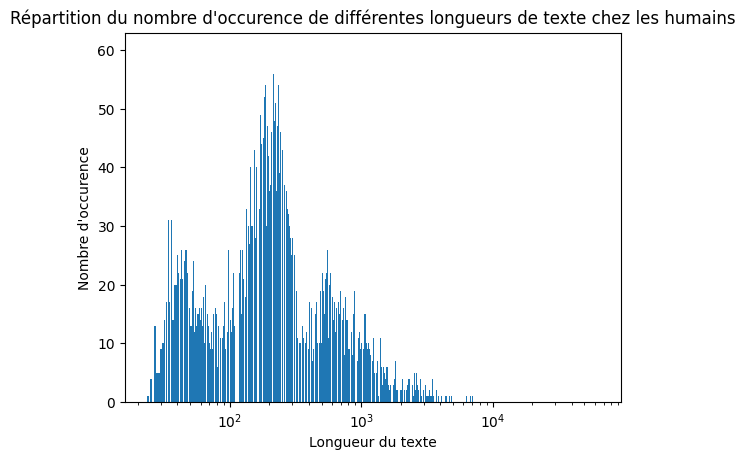

In [16]:
values, count = np.unique(text_df[text_df["label"] == 1]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre d'occurence")
plt.title("Répartition du nombre d'occurence de différentes longueurs de texte chez les humains")
plt.show()

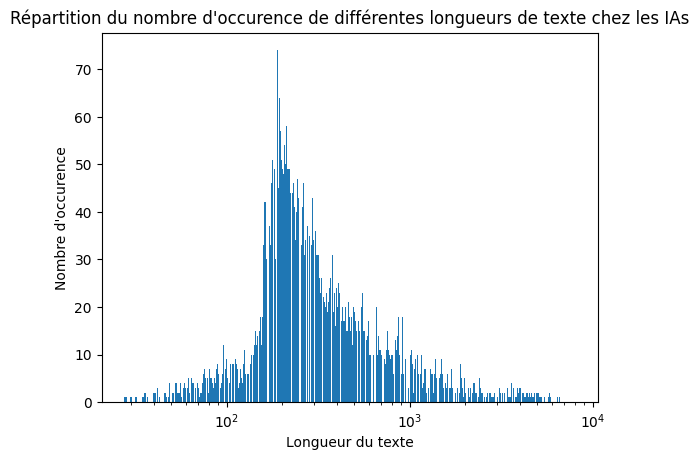

In [17]:
values, count = np.unique(text_df[text_df["label"] == 0]["text_length"].values, return_counts=True)
plt.bar(values, count)
plt.xscale("log")
plt.xlabel("Longueur du texte")
plt.ylabel("Nombre d'occurence")
plt.title("Répartition du nombre d'occurence de différentes longueurs de texte chez les IAs")
plt.show()

On remarque que la longueur des textes écrits par les humains est plus étendue que celle des textes générés par des IAs, qui semble être centrée autour de 200 caractères.

In [27]:
human_df = df[df.label == 1]
human_strings = " ".join(list(human_df['text']))
human_strings = human_strings.lower()
human_tokens = word_tokenize(human_strings)
print("Number of tokens in the human set:", len(human_tokens))
vocab_human = set(human_tokens)
print("Vocabulary size for human set:", len(vocab_human))

ia_df = df[df.label != 1]
ia_strings = " ".join(list(ia_df['text']))
ia_strings = ia_strings.lower()  # Corrected from test_strings.lower()
ia_tokens = word_tokenize(ia_strings)
print("Number of tokens in the non-human set:", len(ia_tokens))
vocab_non_human = set(ia_tokens)
print("Vocabulary size for non-human set:", len(vocab_non_human))

# Calculate the ratio of vocabulary sizes
vocab_ratio = len(vocab_human) / len(vocab_non_human)
print("Vocabulary size ratio (human / non-human):", vocab_ratio)

# Calculate the average token length
avg_token_length_human = sum(len(token) for token in human_tokens) / len(human_tokens)
print("Average token length in the human set:", avg_token_length_human)

avg_token_length_non_human = sum(len(token) for token in ia_tokens) / len(ia_tokens)
print("Average token length in the non-human set:", avg_token_length_non_human)

Number of tokens in the human set: 6814676
Vocabulary size for human set: 125025
Number of tokens in the non-human set: 7092532
Vocabulary size for non-human set: 99359
Vocabulary size ratio (human / non-human): 1.2583158043055989
Average token length in the human set: 4.103762086414673
Average token length in the non-human set: 4.243358225243115


On constate ici que le vocabulaire humain est plus complet que celui des IAs, avec un vocabulaire plus complet d'environ **25%**.  

### Occurences de mots ayants des fautes d'ortographe

La liste des mots bannis a été établi selon les fautes les plus récurrentes dans la langue anglaise (fautes de contraction).

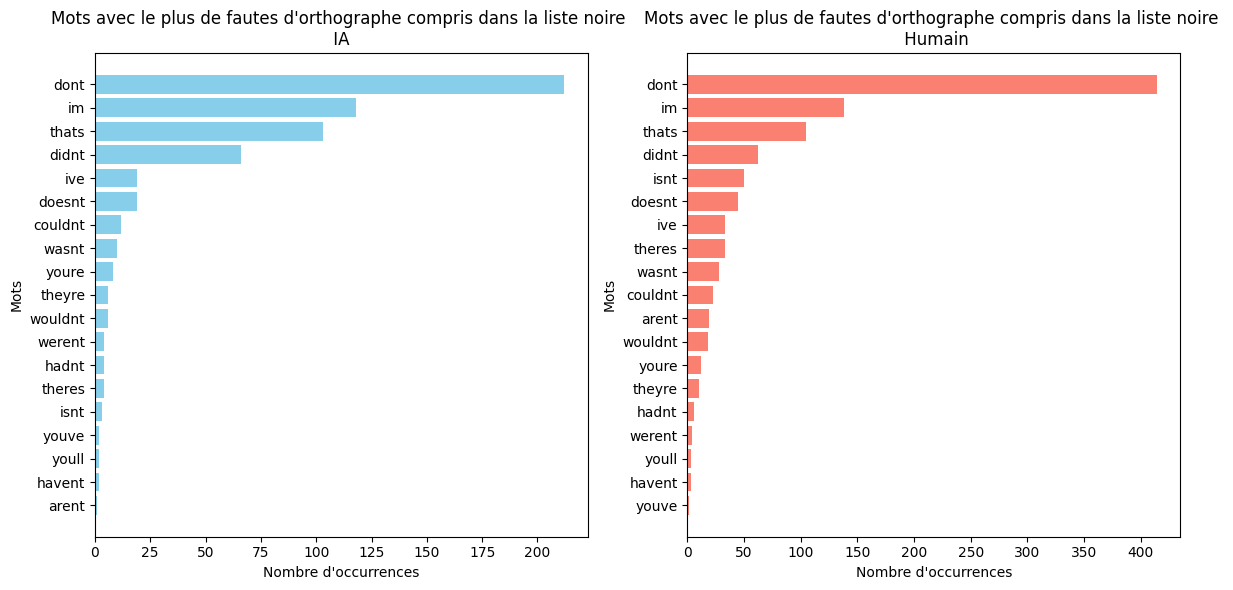

In [28]:
blacklisted_words = {"didnt", "dont", "im", "youre", "ive", "doesnt", "wasnt", "couldnt", "thats", "isnt", "theres", "theyre", "wouldnt", "arent", "youll", "Dont", "youve", "havent", "hadnt", "werent"}

# Dictionnaire pour compter les occurrences des mots de la liste noire dans les textes pour chaque label
blacklisted_counts_label_0 = {word: 0 for word in blacklisted_words}
blacklisted_counts_label_1 = {word: 0 for word in blacklisted_words}

# Parcourir chaque texte pour compter les occurrences exactes des mots de la liste noire
for index, row in df.iterrows():
    text = row['text']
    words_in_text = text.split()
    for word in blacklisted_words:
        for word_in_text in words_in_text:
            if word_in_text.lower() == word.lower():
                if row['label'] == 0:
                    blacklisted_counts_label_0[word.lower()] += 1
                else:
                    blacklisted_counts_label_1[word.lower()] += 1

# Filtrer les mots avec au moins une occurrence pour chaque label
filtered_counts_label_0 = {word: count for word, count in blacklisted_counts_label_0.items() if count > 0}
filtered_counts_label_1 = {word: count for word, count in blacklisted_counts_label_1.items() if count > 0}

# Trier dictionnaire par valeur pour obtenir les mots avec le plus d'occurrences pour chaque label
sorted_counts_label_0 = sorted(filtered_counts_label_0.items(), key=lambda x: x[1], reverse=True)
sorted_counts_label_1 = sorted(filtered_counts_label_1.items(), key=lambda x: x[1], reverse=True)

# Extraction data pour graphique pour label 0
words_label_0 = [word for word, count in sorted_counts_label_0]
counts_label_0 = [count for word, count in sorted_counts_label_0]

# Extraction data pour graphique pour label 1
words_label_1 = [word for word, count in sorted_counts_label_1]
counts_label_1 = [count for word, count in sorted_counts_label_1]

# Tunning graphique pour label 0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(words_label_0, counts_label_0, color='skyblue')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Mots avec le plus de fautes d\'orthographe compris dans la liste noire \n IA ')
plt.gca().invert_yaxis()  

# Tunning graphique pour label 1
plt.subplot(1, 2, 2)
plt.barh(words_label_1, counts_label_1, color='salmon')
plt.xlabel('Nombre d\'occurrences')
plt.ylabel('Mots')
plt.title('Mots avec le plus de fautes d\'orthographe compris dans la liste noire \n Humain')
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

### Nuage de mots sur les réponses humaines

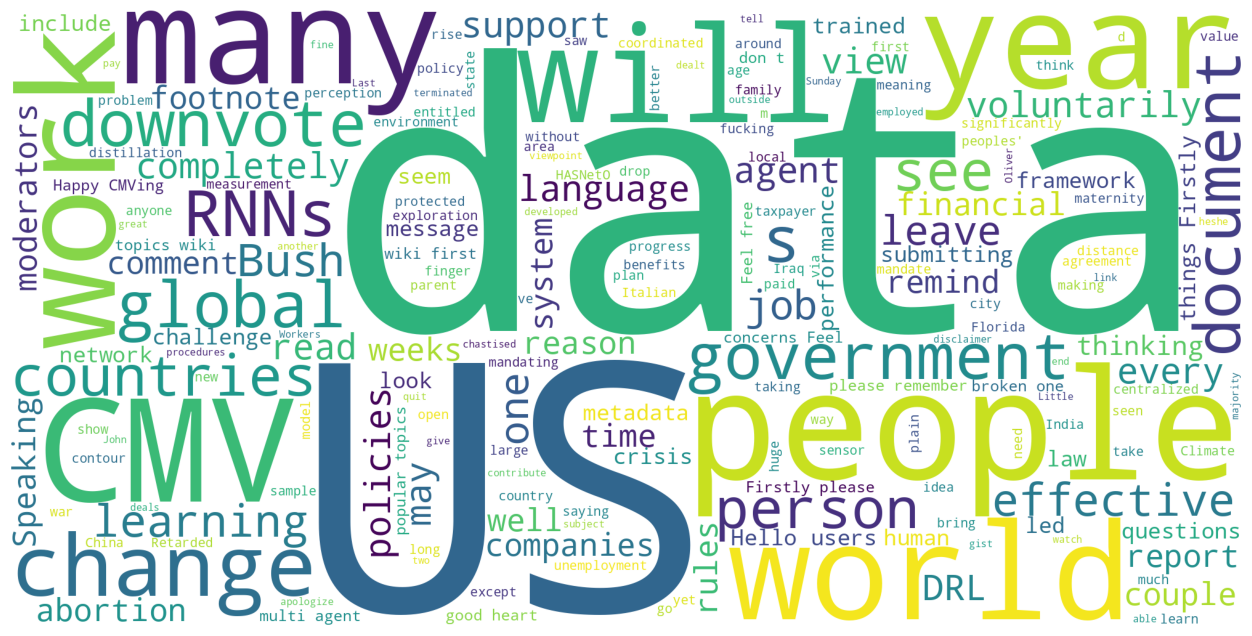

In [19]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 1]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Nuage de mots sur les réponses d'IA

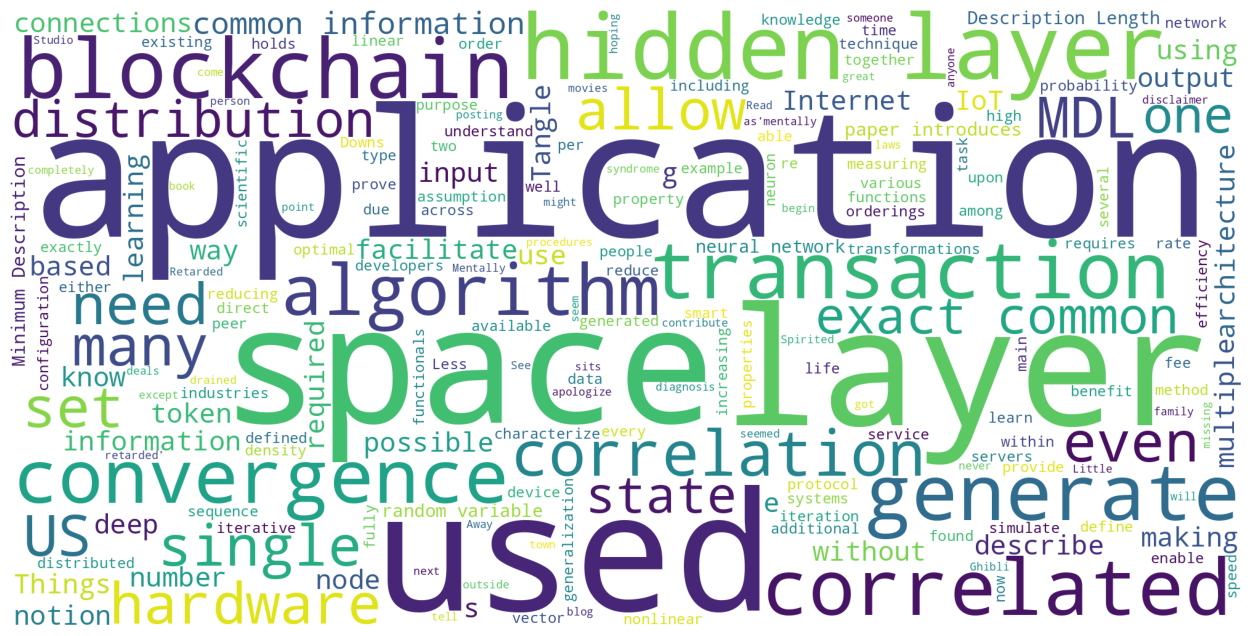

In [20]:
stopwords = set(STOPWORDS)
human = df[df['label'] == 0]
action_text = human['text'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=1000, width=2000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On observe que les mots les plus utilisés par les humains et les IAs sont très différents, avec pour les humains des mots comme "data", "us" ou "people", et pour les IAs des mots comme "application", "space" ou "layer".

### Proportion des textes entre humains et IAs

[Text(0, 0, 'humain'), Text(1, 0, 'IA')]

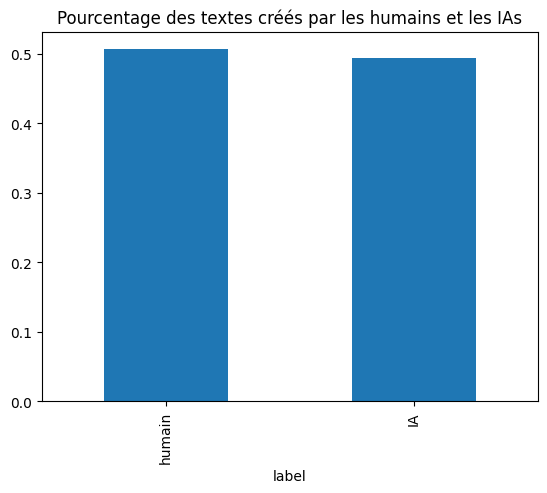

In [21]:
df.value_counts("label", normalize=True).plot(kind="bar", title= "Pourcentage des textes créés par les humains et les IAs").set_xticklabels(('humain', 'IA'))

On remarque une répartition uniforme entre les 2 différents labels, ce qui facilitera l'apprentissage des modèles.

## Benchmark de différents modèles de machine learning
---

Division du dataset en set de testing et de training, avec 80% pour le training et 20% pour le testing (qui nous sert aussi de set de validation par manque de donnée).

In [9]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

#### Entraînement de 5 modèles de machine learning avec un grid search

Le choix des modèles pour le grid search résulte de nos recherches, ces modèles semblent être les plus appropriés pour de la classification binaire de texte, mais on aurait bien aimé en rajouter d'autres qui semblaient aussi prometteur.

La pipeline utilisée pour chaque modèle est plutôt simple, elle consiste d'un **CountVectorizer** qui va nous permettre de transcrire nos chaînes de caractères en vecteurs, et ensuite du modèle que l'on souhaite tester. **CountVectorizer** a été choisi après plusieurs tests avec différentes méthodes d'embedding, notamment **Word2Vec**, **FastText**, **TfIdf**, mais un vecteur avec le nombre d’occurrences de chaque mot du vocabulaire semble être le plus adapté. Nous avons choisi le tokenizer ***punkt*** de ```nltk```.<br><br>

**PS: La réalisation de ce benchmark est très longue, nous vous conseillons de nous faire confiance pour notre choix du meilleur modèle de machine learning résultant de son exécution.**

In [11]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'model__n_estimators': [50, 100, 200]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 1.0]}
    },
    'SVC': {
        'model': SVC(),
        'params': {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
    },
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'model__C': [0.1, 1, 10]}
    },
    'Naive Bayes': {
        'model': MultinomialNB(),
        'params': {'model__alpha': [0.01, 0.1, 1]}
    }
}

grid_search_objects = {}
results = {}

for name, m in models.items():
    pipe = Pipeline([
        ('count_vect', CountVectorizer(tokenizer=word_tokenize, ngram_range=(2, 2))),
        ('model', m['model'])
    ])
    grid_search = GridSearchCV(pipe, m['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_search_objects[name] = grid_search
    results[name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

for name, res in results.items():
    print(f"{name}: Meilleure précision = {res['best_score']}")
    print(f"Meilleurs paramètres : {res['best_params']}")


#### Evaluation avec les données de tests des meilleurs modèles

In [ ]:
for name, grid_search in grid_search_objects.items():
    best_model = grid_search.best_estimator_
    
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{name} Test Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Prediction Time: {prediction_time} seconds")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

## Optimisation du meilleur modèle de machine learning
---

Avec le benchmark que l'on vient d'effectuer, on se rend vite compte que le modèle de machine learning le plus performant est la **régression logistique**, c'est pourquoi on va continuer à améliorer ce modèle avec une plus grande *grid search* et une augmentation de la taille des ngrams du **CountVectorizer**. On va aussi utiliser une validation croisée pour avoir de meilleures métriques sur les performances de notre modèle.

#### Grid search and cross validation

In [ ]:
param_grid = {'logisticregression__max_iter': [100, 500, 1000], 'logisticregression__tol': [1e-4, 1e-5]}
model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(3, 3)), LogisticRegression())

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres trouvés via la recherche sur la grille : {grid_search.best_params_}")
print(f"Meilleure précision lors de la validation croisée : {grid_search.best_score_}")

Inférence sur les données de test :

In [ ]:
best_log_reg = grid_search.best_estimator_

start = time.time()
y_pred = best_log_reg.predict(X_test)
print(f"Temps d'inférence: {time.time() - start}")

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Matrice de confusion :

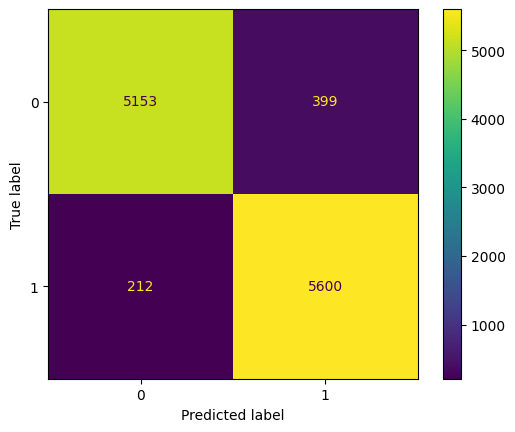

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot()
plt.show()

## Modèles de deep learning
---
Conversion de la donnée en dataset ```tensorflow``` pour l'entraînement des modèles :

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values)).shuffle(5000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values)).batch(32)

### RNN

Entraînement d'une couche de vectorisation et définition du modèle.

In [ ]:
encoder = tf.keras.layers.TextVectorization()
encoder.adapt(train_dataset.map(lambda text, _: text))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1)
])

Compilation, entraînement et test du modèle RNN.

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    min_delta=0.1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.AdamW(1e-4),
              metrics=['accuracy']
             )

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

### RNN avec BERT

Importation d'un modèle **BERT** pré-entraîné et création d'un dataset spécial avec le tokenizer lié au modèle de **BERT**.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

max_len = 120
X_train = tokenizer(
    text=df_train['text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

Définition du modèle **BERT** et **RNN**.

In [ ]:
class OwnBert(tf.keras.Layer):
    def call(self, ids, mask):
        return bert(ids, attention_mask=mask)[0]
    
x = OwnBert()(input_ids, input_mask)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=x)
model.layers[2].trainable = True # permet le training sur le modèle BERT déjà existant

Compilation, entraînement et test du modèle **BERT** et **RNN**.

In [ ]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    metrics=['accuracy']
)

history = model.fit(
    x = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y = df_train['label'],
    validation_data = ({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, df_test['label']),
    epochs=10,
    batch_size=32
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.AdamW(1e-5),
    metrics=['accuracy']
)

history = model.fit(
    x = {'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y = df_train['label'],
    validation_data = ({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, df_test['label']),
    epochs=1,
    batch_size=32
)

test_loss, test_acc = model.evaluate(x = {'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, y = y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

## Conclusion
---

In [24]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range=(3, 3)), LogisticRegression(max_iter=500, random_state=42))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Classification Report:\n{classification_report(y_test, y_pred, digits=4)}")

Classification Report:
              precision    recall  f1-score   support

           0     0.9605    0.9281    0.9440      5552
           1     0.9335    0.9635    0.9483      5812

    accuracy                         0.9462     11364
   macro avg     0.9470    0.9458    0.9462     11364
weighted avg     0.9467    0.9462    0.9462     11364



Notre meilleur modèle de machine learning est donc la régression logistique couplée au CountVectorizer de **scikit**, qui utilise le tokenizer **punkt** de ```nltk```.<br>
CountVectorizer fait ressortir les features importantes que nous avons observé sur ce dataset lors de l'analyse des données, par les différences entre le texte créé par un humain et celui généré par une IA, notamment sur les critères de longueur de texte, la diversité des mots utilisés, le nombre de faute d'orthographes etc...<br>
Avec les hyper-paramètres que nous avons trouvé pour la régression logistique, nous obtenons une précision d'environ **95%**.
<br><br>
Quant au deep learning, le modèle le plus performant est le **RNN** couplé au modèle **BERT** pré-entraîné (par Google) avec aussi **95%** de précision. Avec le peu de donnée mise à disposition, nous sommes content de ce résultat, car les modèles de **deep learning** nécessitent souvent une donnée par paramètre pour être performant, mais le notre arrive quand même à converger assez rapidement.
<br><br><br>
Le temps d'inférence (inference_time dans le tableau) est calculé pour l'inférence de **20%** du dataset, soit environ **11300** lignes.

|         x          | Random forest | Gradient boost | SVM     | Naive Bayes | Logistic Reg | RNN   | BERT RNN |
| ------------------ | ------------- | -------------- | ------- | ----------- | ------------ | ----- | -------- |
| precision_test     | 0.86          | 0.77           | 0.79    | 0.73        | ***0.95***   | 0.92  | ***0.95***     |
| temps_inference    | 8s            | 2.7s           | 195s    | ***2s***    | 3s           | 8s    | 8s       |
| conso_entraînement | basse         | basse          | moyenne | basse       | moyenne      | haute | haute    |